## $\kappa$-velo on pancreas - low u/s genes

This notebook focuses on the application of $\kappa$-velo on the pancreas endocrinogenesis dataset. This dataset was originally published by Bastidas-Ponce and colleagues (https://doi.org/10.1242/dev.173849) and it is one of the datasets described in the original scVelo paper. More specifically, we will focus on a step in the processing pipeline of $\kappa-velo$. In this step we remove the genes with insufficient spliced and unspliced counts

This notebook can be used to recreate figures S9-11.

In [1]:
### load libraries

# standard libraries
import pandas as pd
import numpy as np

# single-cell libraries
import anndata as ad
import scanpy as sc
import scvelo as scv

# plotting libraries
import matplotlib.pyplot as plt
import seaborn as sns

# other
import copy
from collections import Counter
import os
import sklearn as sk #used for L2 normalization
import sklearn.preprocessing #used for L2 normalization
import scipy #for transforming matrix from sparse to dense 
from scipy.spatial import cKDTree #used for MNN method
from matplotlib import rcParams # for changing the parameters of the scVelo figures

# load our own 
from functions import *

In [2]:
### set scvelo settings
scv.set_figure_params(style='scvelo', dpi=100, dpi_save=300, frameon=False, vector_friendly=True, transparent=True, 
                         fontsize=10, figsize=None, color_map=None, facecolor=None, format='png')
scv.settings.verbosity = 0

### Load original dataset

Here, we load the pancreas endocrinogenesis dataset. The dataset is made accesible in the scVelo package (version 0.2.4) where you can download it using the function `scvelo.datasets.pancreas()`. 

In [3]:
### load pancreas dataset
pancreas_path = "../datasets/pancreas/pancreas.h5ad"
adata = ad.read_h5ad(pancreas_path)

In [4]:
adata

AnnData object with n_obs × n_vars = 3696 × 27998
    obs: 'clusters_coarse', 'clusters', 'S_score', 'G2M_score'
    var: 'highly_variable_genes'
    uns: 'clusters_coarse_colors', 'clusters_colors', 'day_colors', 'neighbors', 'pca'
    obsm: 'X_pca', 'X_umap'
    layers: 'spliced', 'unspliced'
    obsp: 'distances', 'connectivities'

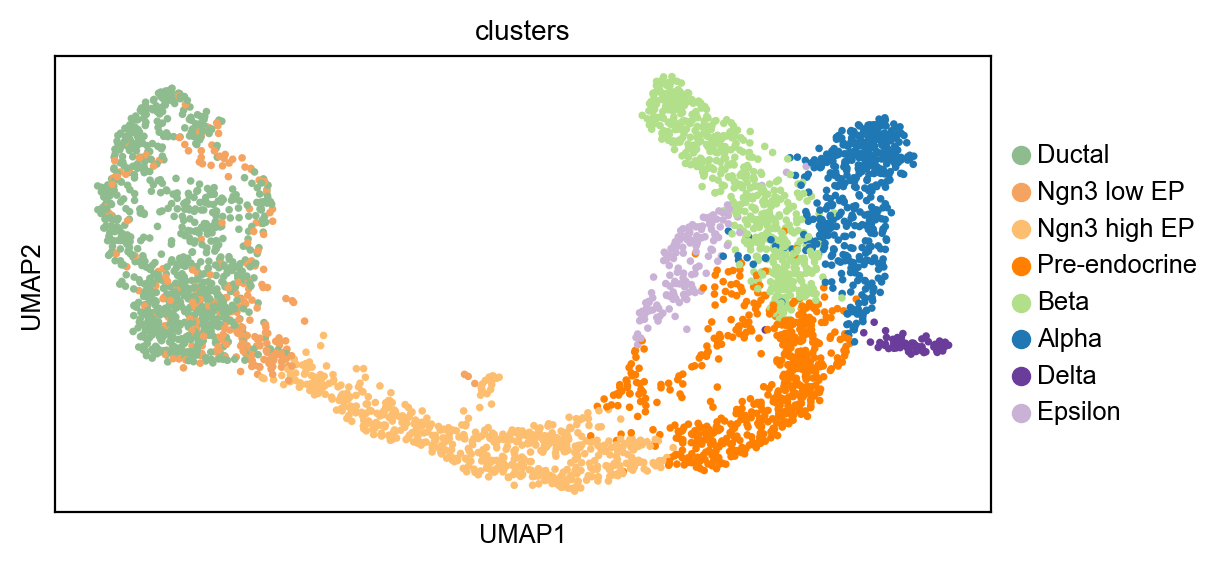

In [5]:
### plot dataset
fig, axs = plt.subplots(1, 1, figsize=(6, 3), frameon=False)
sc.pl.umap(adata, color="clusters", size=30, ax=axs)

### Step 1: select HVGs

The first step in processing is the selection of HVGs. 

In [6]:
### select HVGs
hvgs = get_hvgs(adata, no_of_hvgs=5000, theta=100)

In [7]:
### make subset with HVGs only
adata = adata[:, hvgs]

### Step 2:  select genes with sufficient u and s counts
Normally, we select only genes with sufficient u and s counts. Below, we will show what happens after imputation and recovery of the dynamics to genes with very low counts. The figures correspond to figure S9.

In [8]:
### subset for genes that have high enough U and S counts
minlim = 3
spliced_matrix = adata.layers['spliced'].todense()
unspliced_matrix = adata.layers['unspliced'].todense()
us_genes = (np.array(np.max(spliced_matrix, axis=0)).flatten() > minlim) & (np.array(np.max(unspliced_matrix, axis=0)).flatten() > minlim)
us_genes = adata.var_names[us_genes]
len(us_genes)

716

In [11]:
### select genes to follow in the following preprocessing and downstream steps
test_low_us_genes = ['Acly', 'Dpysl2', 'Gnaz']

In [10]:
adata_test = adata.copy()

In [ ]:
### convert matrices from sparse to dense
adata.X = adata.X.todense()
adata.layers['spliced'] = adata.layers['spliced'].todense()
adata.layers['unspliced'] = adata.layers['unspliced'].todense()

### 4. Preprocessing

In [10]:
### convert matrices from sparse to dense
adata.X = adata.X.todense()
adata.layers['spliced'] = adata.layers['spliced'].todense()
adata.layers['unspliced'] = adata.layers['unspliced'].todense()

In [11]:
### select genes to follow in the following preprocessing and downstream steps
test_genes = ['Acly', 'Dpysl2', 'Gnaz']

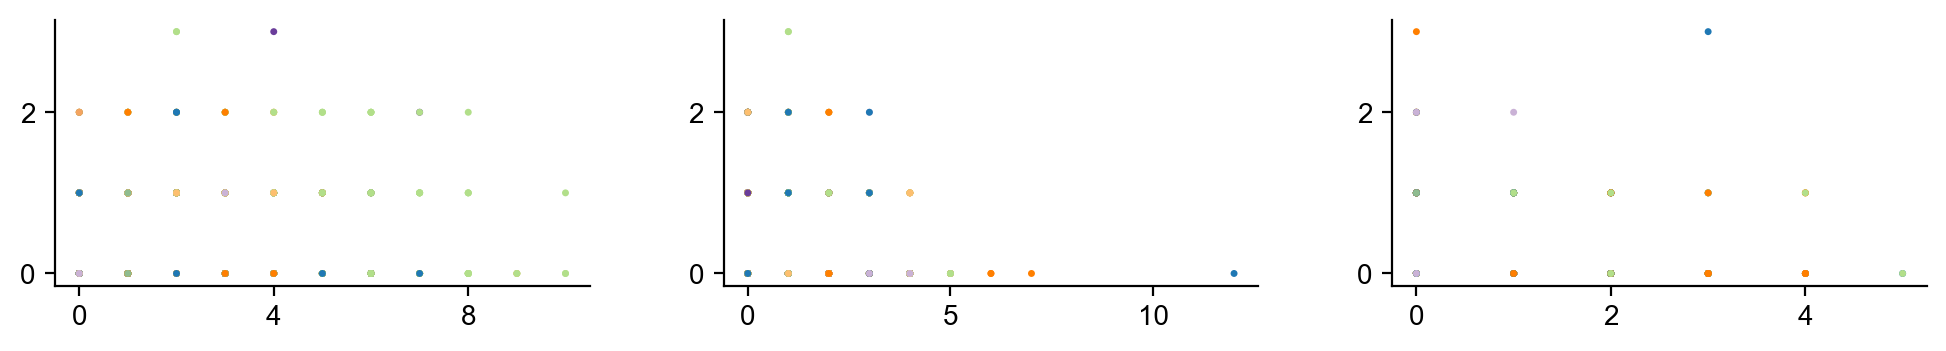

In [12]:
### plot genes of interest before preprocessing
rcParams["axes.grid"] = False
rcParams["axes.spines.right"] = False
rcParams["axes.spines.top"] = False
scv.set_figure_params(style=None,figsize = (4,1.75))
save_path = "figures/raw_counts_"+'_'.join(test_genes)+".png"
scv.pl.scatter(adata, test_genes, ncols=3, wspace=0.25, s=25, save=save_path, xlabel="", ylabel="", title="")

In [13]:
### L1 normalize unspliced and spliced together
adata = L1_normalize(adata)

### 5. Impute counts

In [14]:
### scale data
scal = StandardScaler()
spliced_scaled = scal.fit_transform(adata.layers["spliced"])

In [15]:
### run PCA
n_pcs = 15
pca = PCA(n_components=n_pcs)
pca.fit(spliced_scaled)
pca_embedding = pca.transform(spliced_scaled)

In [16]:
### delete original PCA and UMAP
del adata.obsm['X_pca']
del adata.obsm['X_umap']

In [17]:
### add PCA to adata object
adata.obsm['X_pca'] = pca_embedding

In [18]:
### calculate moments
scv.pp.moments(adata, n_pcs=n_pcs, n_neighbors=30)

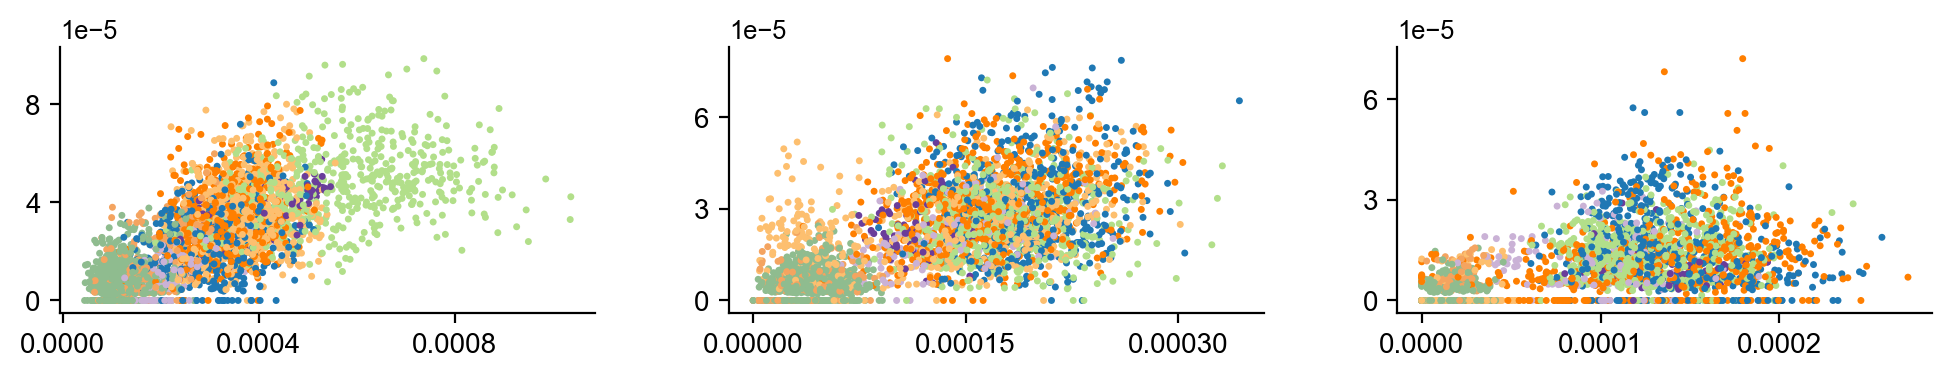

In [19]:
### plot genes of interest after imputation
rcParams["axes.grid"] = False
rcParams["axes.spines.right"] = False
rcParams["axes.spines.top"] = False
scv.set_figure_params(style=None,figsize = (4,1.75))
save_path = "figures/imputed_counts_"+'_'.join(test_genes)+".png"
scv.pl.scatter(adata, test_genes, ncols=3, wspace=0.25, s=25, save=save_path, title="", xlabel="", ylabel="")

### 6. Recover dynamics

In [20]:
### recover dynamics for all genes
scv.tl.recover_dynamics(adata, var_names=test_genes, n_jobs=8, t_max=100, fit_connected_states=True, max_iter=10)

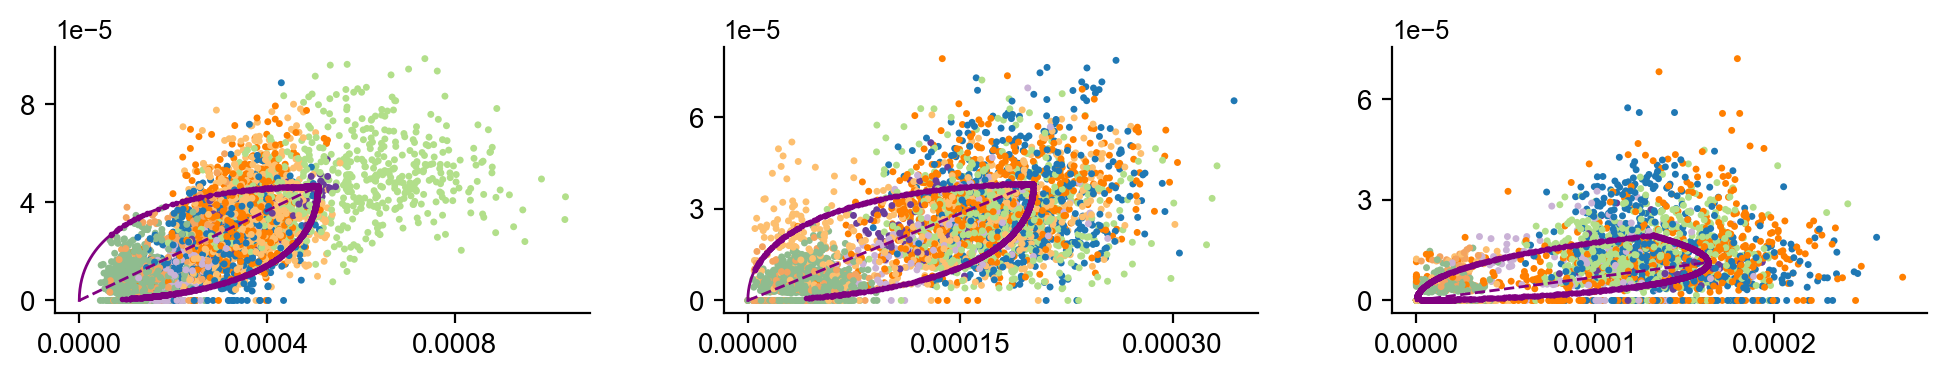

In [21]:
### plot genes of interest after recovering dynamics
rcParams["axes.grid"] = False
rcParams["axes.spines.right"] = False
rcParams["axes.spines.top"] = False
scv.set_figure_params(style=None,figsize = (4,1.75))
save_path = "figures/recovered_dynamics_"+'_'.join(test_genes)+".png"
scv.pl.scatter(adata, test_genes, ncols=3, wspace=0.25, s=25, save=save_path, title="", xlabel="", ylabel="")